In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib.colors import LogNorm

def parsefn(x):
    return tuple([int(x.split('_')[1]) for x in Path(x).stem[5:].split('-')])

sns.set_context('talk')

In [2]:
def plot(dfy, colA, colB, hue):
    plt.figure(figsize=(7,5))
    plt.vlines(1,0,dfy[colA].max(), color='k',alpha=0.5, lw=1)
    plt.hlines(1,0,dfy[colB].max(), color='k',alpha=0.5, lw=1)
    m = min(dfy[colB].max(), dfy[colA].max())
    plt.plot([0,m],[0,m],color='k', lw=1, alpha=0.5)
    plt.scatter(dfy[colB], dfy[colA], c = dfy[hue], s=5, norm=LogNorm())
    plt.xscale("log")
    plt.yscale("log")
    plt.colorbar(label=hue)
    plt.xlabel(colB+'\nfactor rel openfst')
    plt.ylabel(colA+'\nfactor rel openfst')

In [3]:
dffsac = pd.read_csv("../data/fsadb_uw_composed.csv")
dffsac = dffsac[dffsac['nstates']!=0]

<Axes: xlabel='nstates', ylabel='narcs'>

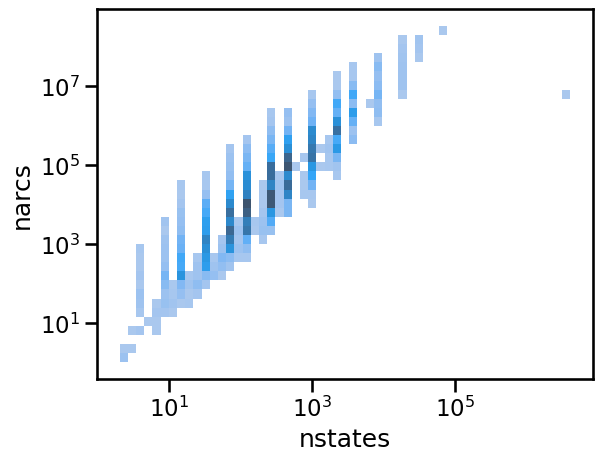

In [4]:
sns.histplot(data=dffsac, x="nstates", y="narcs", fill=True,log_scale=(10,10))

In [65]:
dfbenchk2 = pd.read_csv("../data/fsadb_uw_composed_k2_compbenchs.csv.bk")
dfbenchk2["name"]="k2"
dfbenchk2[["min","max","mean","std"]] = dfbenchk2[["min","max","mean","std"]]*1e9
print(len(dfbenchk2))

dfbenchk2cuda = pd.read_csv("../data/fsadb_uw_composed_k2_cuda_compbenchs.csv")
dfbenchk2cuda["name"]="k2cuda"
dfbenchk2cuda[["min","max","mean","std"]] = dfbenchk2[["min","max","mean","std"]]*1e9
print(len(dfbenchk2cuda))

3365
646


In [66]:
dfbenchk2cuda['fileC'] = dfbenchk2cuda['fileC'].map(lambda x: x[5:] if isinstance(x,str) else None)

In [67]:
dfbench = pd.concat([pd.read_csv("../data/fsadb_uw_TensorFSTs_compbenchs.csv.bk"),
           pd.read_csv("../data/fsadb_uw_CooOfCooLod_compbenchs.csv.bk"),
           pd.read_csv("../data/fsadb_uw_CooOfCooMT_compbenchs.csv.bk"),
           pd.read_csv("../data/fsadb_uw_CscOfCoo_compbenchs.csv.bk"),
           pd.read_csv("../data/fsadb_uw_OpenFst_compbenchs.csv.bk") 
          ])
dfbench = pd.concat([dfbench, dfbenchk2,dfbenchk2cuda])

systems = ["OpenFst", "CooOfCoo", "CooOfCooMT", "CscOfCoo", "TensorFSTs", "k2"]

In [68]:
dfbench['specsA'] = dfbench['fileA'].map(parsefn)
dfbench['specsB'] = dfbench['fileB'].map(parsefn)
dfbench['minimum_time_seconds'] = dfbench['min']/1e9
dfbench['mean_time_seconds'] = dfbench['mean']/1e9
dfbench = dfbench.rename(columns = {'nstates':'nstatesC','narcs':'narcsC'})

In [69]:
dfs = []
for k,g in dfbench.groupby('fileC'):
    if len(g)>0 and "OpenFst" in g["name"].tolist():
        g["time_rel_openfst"] =  g["minimum_time_seconds"]/(g[g["name"]=="OpenFst"]["minimum_time_seconds"]).values
#     g["time_rel_openfst"] =  g["mean_time_seconds"]/(g[g["name"]=="OpenFst"]["mean_time_seconds"]).values
        dfs.append(g)
dfs = pd.concat(dfs)
dfs = pd.concat([dfs,dfs['specsA'].apply(pd.Series).rename(columns={0:"nstatesA", 1:"narcsA", 2:"nsymsA", 3:"seedA"})],axis=1)
dfs = pd.concat([dfs,dfs['specsB'].apply(pd.Series).rename(columns={0:"nstatesB", 1:"narcsB", 2:"nsymsB", 3:"seedB"})],axis=1)

minsyms = 16
dfs = dfs[(dfs['nsymsB']>minsyms) & (dfs['nsymsA']>minsyms)]

In [70]:
dfs['name'].unique()

array(['TensorFSTs', 'CooOfCoo', 'CooOfCooMT', 'CscOfCoo', 'OpenFst',
       'k2', 'k2cuda'], dtype=object)

In [71]:
dfs["sparsityA"]=1-dfs["narcsA"]/(dfs['nstatesA']**2*dfs['nsymsA'])
dfs["lognarcsA"]=np.log10(dfs["narcsA"])
dfs["lognstatesA"]=np.log10(dfs["nstatesA"])
dfs["lognsymsA"]=np.log10(dfs["nsymsA"])
dfs["sparsityB"]=1-dfs["narcsB"]/(dfs['nstatesB']**2*dfs['nsymsB'])
dfs["lognarcsB"]=np.log10(dfs["narcsB"])
dfs["lognstatesB"]=np.log10(dfs["nstatesB"])
dfs["lognsymsB"]=np.log10(dfs["nsymsB"])
dfs["avgnsyms"]=(dfs["nsymsB"]+dfs["nsymsA"])/2
dfs["avgnstates"]=(dfs["nstatesB"]+dfs["nstatesA"])/2
dfs["avgnarcs"]=(dfs["narcsB"]+dfs["narcsA"])/2
dfs["avgsparsity"]=(dfs["sparsityA"]+dfs["sparsityB"])/2

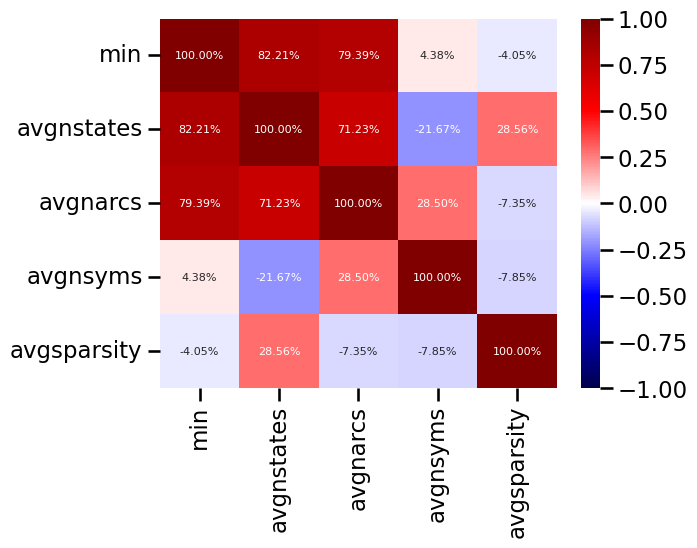

In [72]:
cc = dfs[dfs["name"]=="OpenFst"][['min','avgnstates', 'avgnarcs', 'avgnsyms',  'avgsparsity']].corr(method='spearman')
# plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cc, vmin=-1, vmax=1, annot=True,  fmt=".2%",annot_kws={"size":8}, cmap='seismic')

In [73]:
# dfx = dfs[dfs["name"]=="OpenFst"]
# for c in ['avgnstates', 'avgnarcs', 'avgnsyms',  'avgsparsity']:
#     plt.figure()    
#     plt.scatter(dfx[c], dfx['min'],s=10)    
# plt.yscale('log')

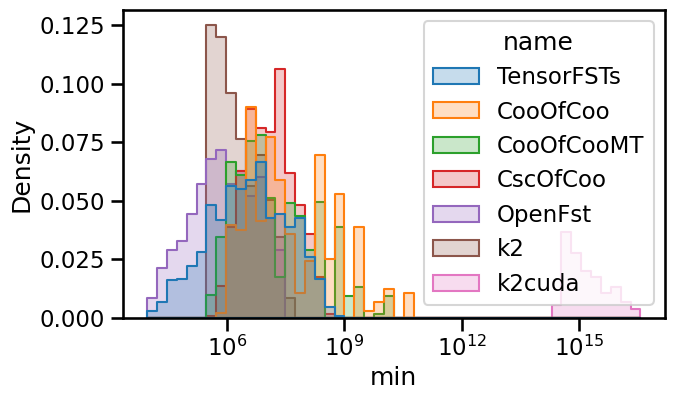

In [74]:
plt.figure(figsize=(7,4))
# plt.vlines(1,0,1, color='k',lw=1)
g = sns.histplot(data=dfs,bins=50, x="min", hue="name", element="step", stat="density", log_scale=True)
# plt.xlim(0.4,50);
# plt.xlabel("factor relative to OpenFst (<1 better)")

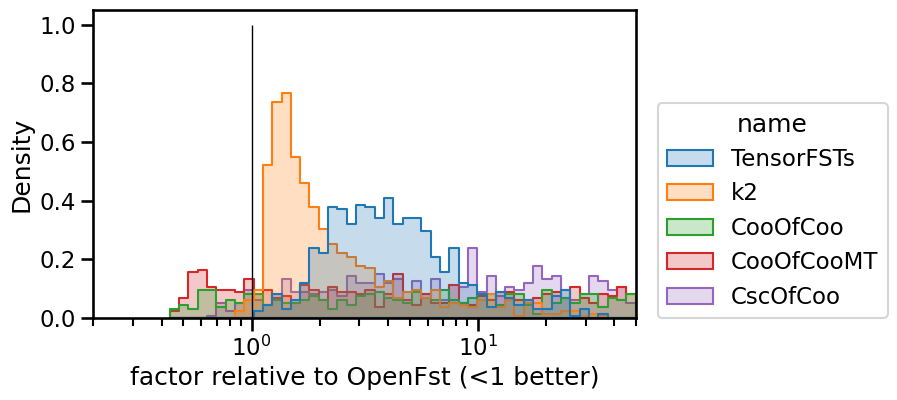

In [75]:
plt.figure(figsize=(7,4))
plt.vlines(1,0,1, color='k',lw=1)
g = sns.histplot(data=dfs[(dfs["time_rel_openfst"]<50) & (dfs["name"]!="OpenFst")],bins=50, x="time_rel_openfst", hue="name",  element="step", stat="density", log_scale=True)
plt.xlim(0.2,50);
plt.xlabel("factor relative to OpenFst (<1 better)")
sns.move_legend(plt.gca(),loc=(1.04, 0 ), ncol=1)

In [15]:
# np.vstack([
#     dfs[dfs["name"]=="TensorFSTs"].sort_values('time_rel_openfst').iloc[-4:][['fileA','fileB','fileC']].values,
#     dfs[dfs["name"]=="CooOfCoo"].sort_values('time_rel_openfst').iloc[-4:][['fileA','fileB','fileC']].values
# ])

In [17]:
# dfs[dfs['time_rel_openfst']<1].value_counts(['nsymsA','nsymsB', 'nstatesA', 'nstatesB', 'narcsA', 'narcsB'])

In [18]:
dfy = pd.pivot_table(dfs, "time_rel_openfst", "fileC", "name")
dfy = pd.concat([dfy, dfs[dfs["name"]=="OpenFst"].set_index("fileC")],axis=1)

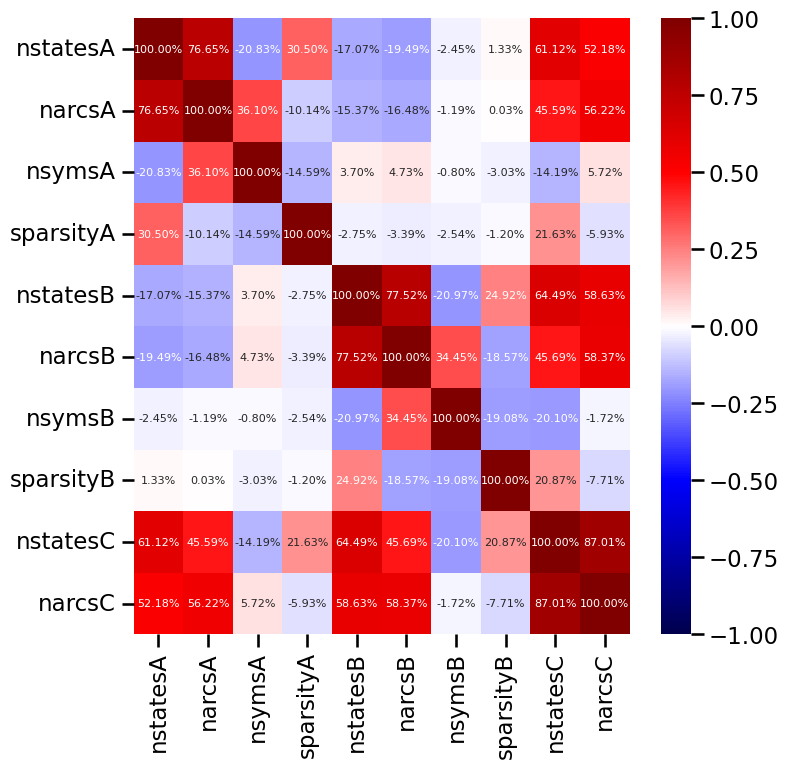

In [19]:
cc = dfy[['nstatesA', 'narcsA', 'nsymsA',  'sparsityA', 'nstatesB', 'narcsB', 'nsymsB', 'sparsityB', 'nstatesC', 'narcsC']].corr(method='spearman')
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(cc, vmin=-1, vmax=1, annot=True,  fmt=".2%",annot_kws={"size":8}, cmap='seismic')

In [20]:

# dfy = dfy[~dfy['k2'].isna()]

In [21]:
# cc = dfy[['CooOfCoo', 'TensorFSTs','k2', 'nstatesA', 'narcsA', 'nsymsA', 'seedA', 'nstatesB',
#        'narcsB', 'nsymsB', 'seedB', 'sparsityA', 'lognarcsA', 'lognstatesA',
#        'lognsymsA', 'sparsityB', 'lognarcsB', 'lognstatesB', 'lognsymsB' ]].corr()

# display(cc[['CooOfCoo', 'TensorFSTs','k2']].loc[['nstatesA', 'narcsA', 'nsymsA']])

# display(cc[['CooOfCoo', 'TensorFSTs','k2']].loc[['lognstatesA', 'lognarcsA', 'lognsymsA']])

# display(cc[['CooOfCoo', 'TensorFSTs','k2']].loc[['lognstatesA', 'lognarcsA', 'nsymsA']])

In [22]:
cc = dfy[systems+['nstatesA', 'narcsA', 'nsymsA', 'seedA', 'nstatesB',
       'narcsB', 'nsymsB', 'seedB', 'sparsityA', 'lognarcsA', 'lognstatesA',
       'lognsymsA', 'sparsityB', 'lognarcsB', 'lognstatesB', 'lognsymsB', 'nstatesC', 'narcsC']].corr(method='spearman')

cols = ['nstatesA', 'narcsA', 'nsymsA', 'nstatesB','narcsB', 'nsymsB', 'nstatesC', 'narcsC']

display(cc[systems].loc[cols])
# print(cc[['CooOfCoo', 'TensorFSTs','k2']].loc[cols].to_latex(escape=False,float_format="%.2f",))
print(cc[systems].loc[cols].to_html(float_format="%.2f"))

,OpenFst,CooOfCoo,CooOfCooMT,CscOfCoo,TensorFSTs,k2
nstatesA,NaN,-0.458688,-0.465724,-0.484846,0.261888,-0.331159
narcsA,NaN,-0.072144,-0.095114,-0.260327,0.499487,-0.388158
nsymsA,NaN,0.663995,0.632042,0.400205,0.311628,-0.096310
nstatesB,NaN,-0.435421,-0.457449,-0.529185,0.071188,-0.711499
narcsB,NaN,-0.184552,-0.206210,-0.274380,0.416472,-0.689281
nsymsB,NaN,0.433632,0.432846,0.466837,0.504904,-0.007650
nstatesC,NaN,-0.717431,-0.741524,-0.803079,0.250373,-0.829846
narcsC,NaN,-0.539958,-0.568880,-0.744385,0.431432,-0.888093


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>OpenFst</th>
      <th>CooOfCoo</th>
      <th>CooOfCooMT</th>
      <th>CscOfCoo</th>
      <th>TensorFSTs</th>
      <th>k2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>nstatesA</th>
      <td>NaN</td>
      <td>-0.46</td>
      <td>-0.47</td>
      <td>-0.48</td>
      <td>0.26</td>
      <td>-0.33</td>
    </tr>
    <tr>
      <th>narcsA</th>
      <td>NaN</td>
      <td>-0.07</td>
      <td>-0.10</td>
      <td>-0.26</td>
      <td>0.50</td>
      <td>-0.39</td>
    </tr>
    <tr>
      <th>nsymsA</th>
      <td>NaN</td>
      <td>0.66</td>
      <td>0.63</td>
      <td>0.40</td>
      <td>0.31</td>
      <td>-0.10</td>
    </tr>
    <tr>
      <th>nstatesB</th>
      <td>NaN</td>
      <td>-0.44</td>
      <td>-0.46</td>
      <td>-0.53</td>
      <td>0.07</td>
      <td>-0.71</td>
    </tr>
    <tr>
      <th>narcsB</th>
      <td>NaN</td>
      <td>-0.18</td>
 

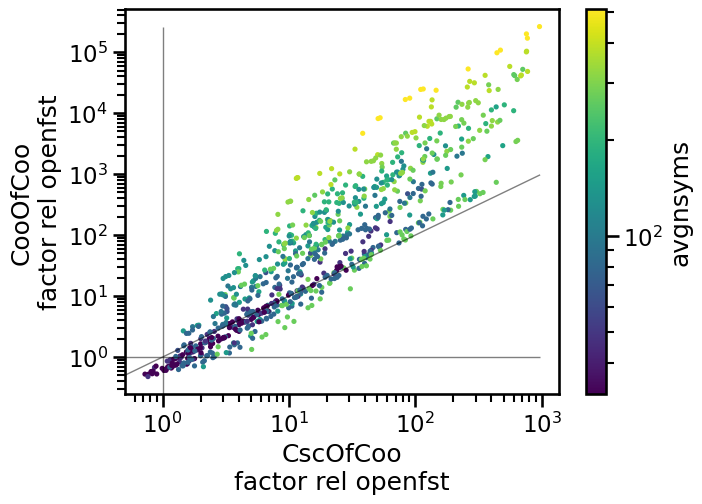

In [23]:
plot(dfy, "CooOfCoo", "CscOfCoo", "avgnsyms")

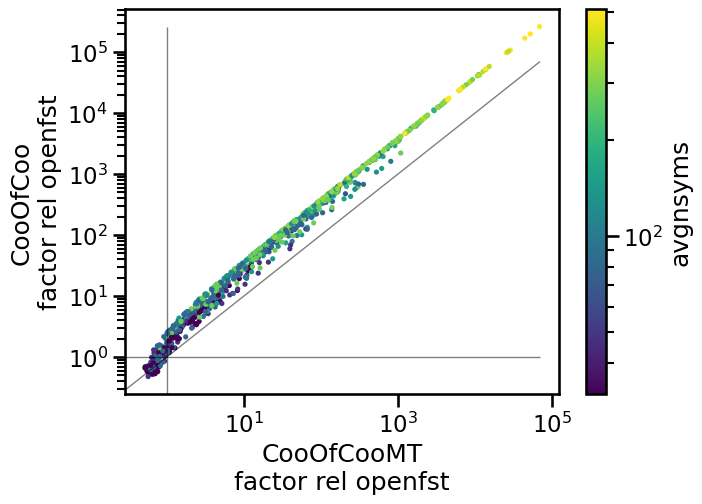

In [24]:
plot(dfy, "CooOfCoo", "CooOfCooMT", "avgnsyms")

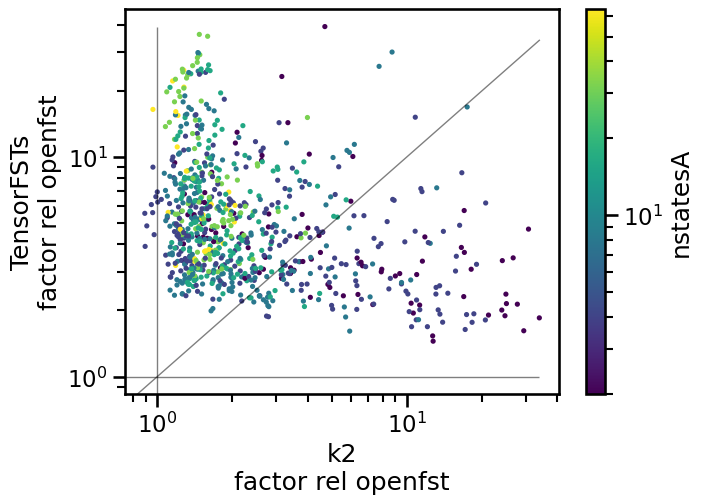

In [25]:
plot(dfy, "TensorFSTs", "k2", "nstatesA")

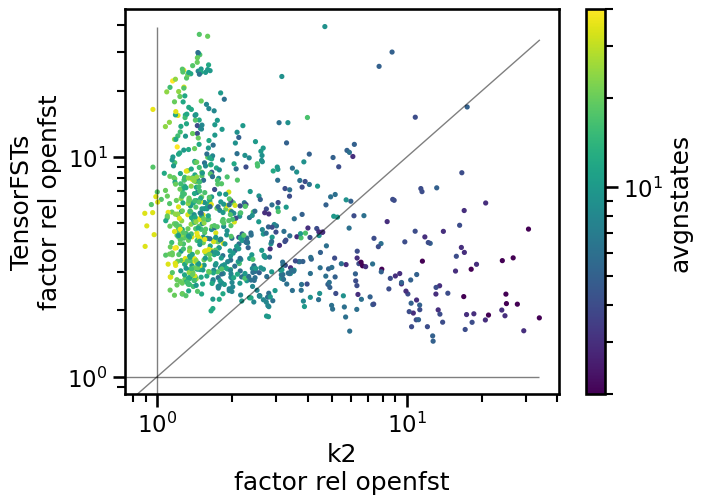

In [26]:
plot(dfy, "TensorFSTs", "k2", "avgnstates")

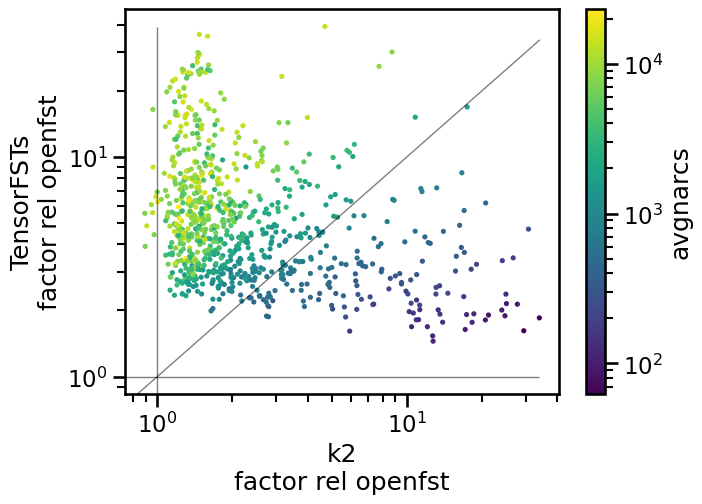

In [27]:
plot(dfy, "TensorFSTs", "k2", "avgnarcs")

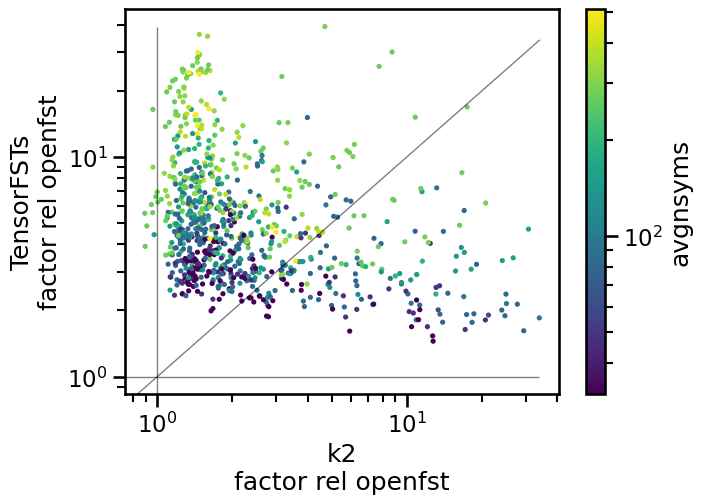

In [28]:
plot(dfy, "TensorFSTs", "k2", "avgnsyms")

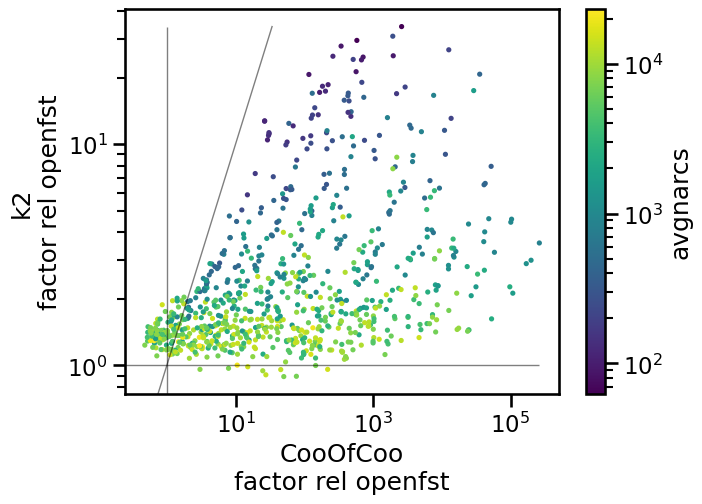

In [29]:
plot(dfy, "k2", "CooOfCoo", "avgnarcs")

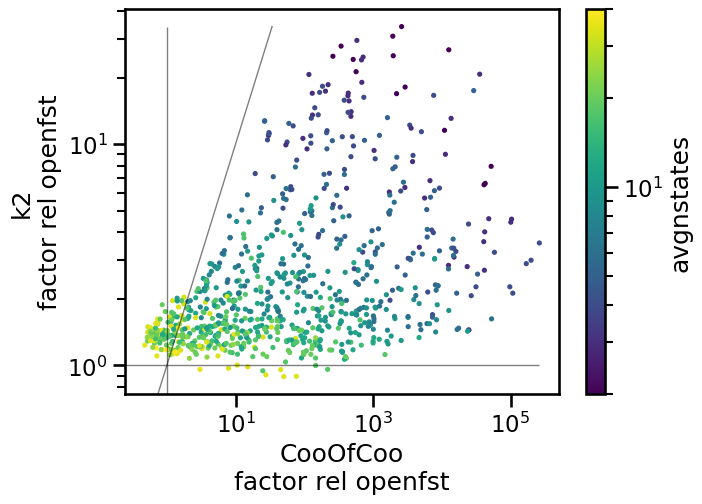

In [30]:
plot(dfy, "k2", "CooOfCoo", "avgnstates")

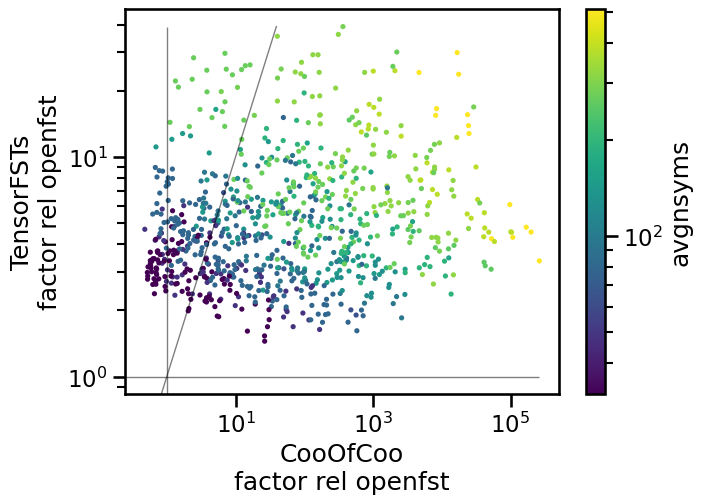

In [31]:
plot(dfy, "TensorFSTs", "CooOfCoo", "avgnsyms")

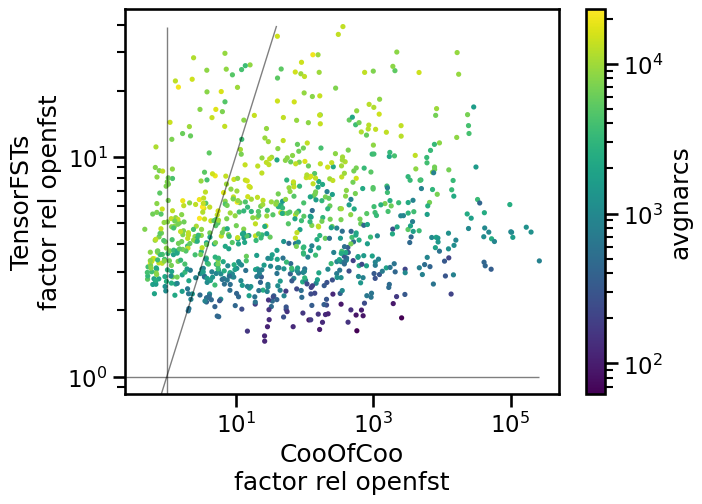

In [32]:
plot(dfy, "TensorFSTs", "CooOfCoo", "avgnarcs")

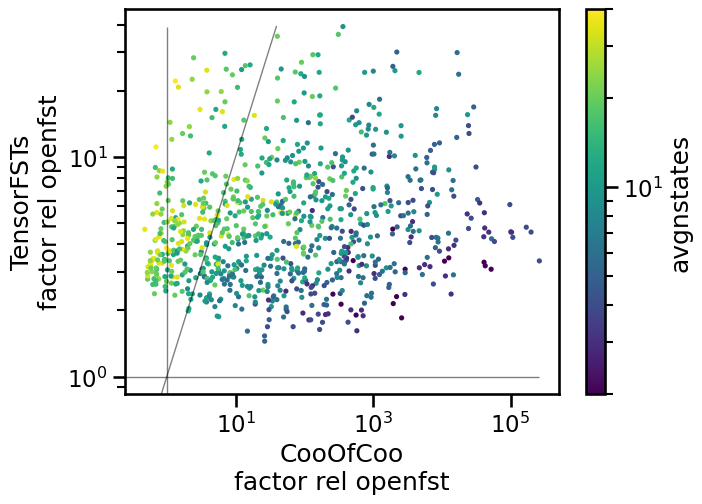

In [33]:
plot(dfy, "TensorFSTs", "CooOfCoo", "avgnstates")

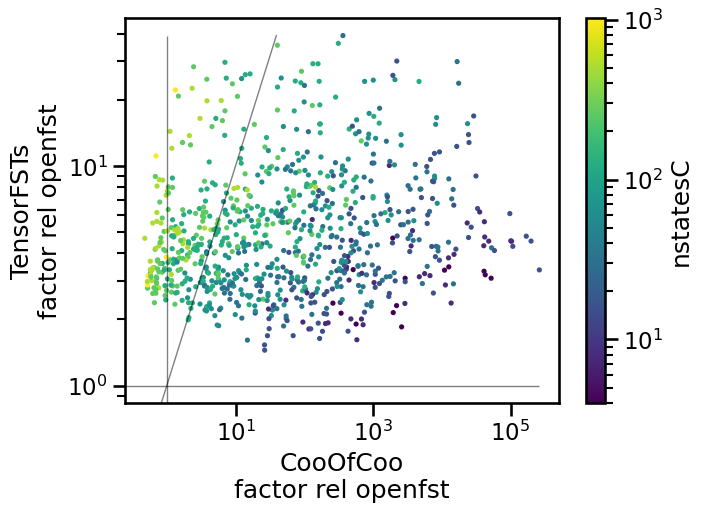

In [34]:
plot(dfy, "TensorFSTs", "CooOfCoo", "nstatesC")

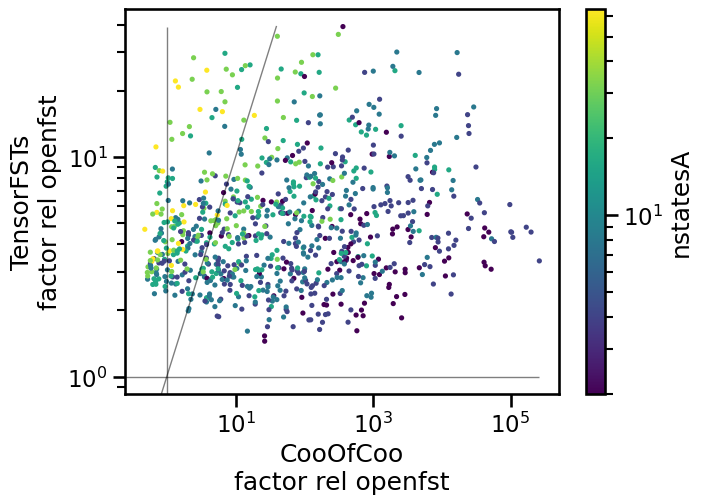

In [35]:
plot(dfy, "TensorFSTs", "CooOfCoo", "nstatesA")

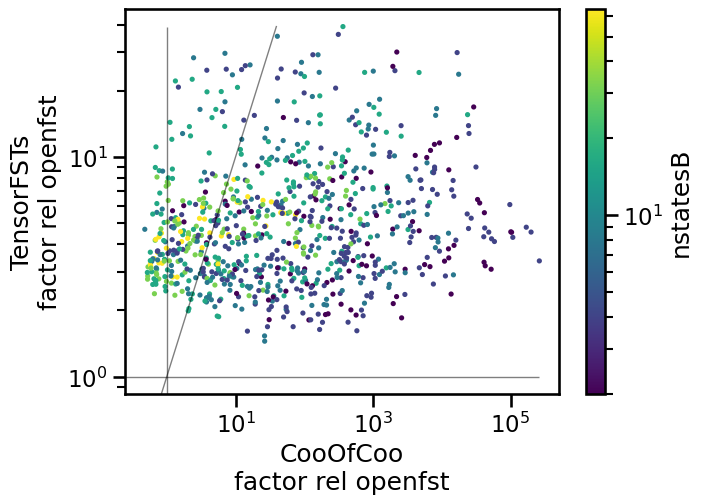

In [36]:
plot(dfy, "TensorFSTs", "CooOfCoo", "nstatesB")